In [1]:
import numpy as np
import pandas as pd
#最大表示列数の指定（ここでは50列を指定）
pd.set_option('display.max_columns', 50)

In [2]:
race_df = pd.read_csv("./csv/race-2008.csv", sep=",")
horse_df = pd.read_csv("./csv/horse-2008.csv", sep=",")
for year in range(2009, 2020):
    race_tmp_df = pd.read_csv("./csv/race-"+str(year)+".csv", sep=",")
    horse_tmp_df = pd.read_csv("./csv/horse-"+str(year)+".csv", sep=",")
    race_df = pd.concat([race_df, race_tmp_df], axis=0)
    horse_df = pd.concat([horse_df, horse_tmp_df], axis=0)

## 元データの確認

In [3]:
# race_id単位で重複したデータが存在しないか確認
print(len(race_df) == len(race_df['race_id'].unique()))
print(race_df.shape)
race_df.tail(2)

True
(3042, 28)


,race_id,race_round,race_title,race_course,weather,ground_status,time,date,where_racecourse,total_horse_number,frame_number_first,horse_number_first,frame_number_second,horse_number_second,frame_number_third,horse_number_third,tansyo,hukusyo_first,hukusyo_second,hukusyo_third,wakuren,umaren,wide_1_2,wide_1_3,wide_2_3,umatan,renhuku3,rentan3
268,201905021209,9 R,薫風ステークス,ダ左1600m,天候 : 晴,ダート : 良,発走 : 14:15\n\n過去の薫風ステークス,2019年5月26日,2回東京12日目,15,6,10,3,4,8,15,420,190,270,140,850,"2,140",890,380,690,"3,390","3,040","14,990"
269,201905010104,4 R,3歳500万下,ダ左1600m,天候 : 晴,ダート : 良,発走 : 11:40,2019年1月26日,1回東京1日目,14,8,13,3,4,6,10,340,170,170,480,550,760,380,"1,130","1,600","1,480","3,870","16,710"


In [4]:
# 出走馬数の確認
race_df["total_horse_number"].value_counts()

16    2220
15     253
14     189
13     126
12     103
11      74
10      47
9       19
8        8
7        3
Name: total_horse_number, dtype: int64

In [5]:
print(horse_df.shape)
horse_df.head(2)

(46375, 19)


,race_id,rank,frame_number,horse_number,horse_id,sex_and_age,burden_weight,rider_id,goal_time,goal_time_dif,time_value,half_way_rank,last_time,odds,popular,horse_weight,tame_time,tamer_id,owner_id
0,200805010502,1,3,4,2005105185,牝3,54.0,1085,1:20.6,NaN,\n\n**\n\n,1-1,37.7,7.6,3.0,454(0),\n\n,1017,853002
1,200805010502,2,6,10,2005106076,牝3,54.0,663,1:20.6,クビ,\n\n**\n\n,3-2,37.6,5.1,2.0,478(0),\n\n,1064,138800


## raceデータの整形

In [6]:
race_df.head(1)

,race_id,race_round,race_title,race_course,weather,ground_status,time,date,where_racecourse,total_horse_number,frame_number_first,horse_number_first,frame_number_second,horse_number_second,frame_number_third,horse_number_third,tansyo,hukusyo_first,hukusyo_second,hukusyo_third,wakuren,umaren,wide_1_2,wide_1_3,wide_2_3,umatan,renhuku3,rentan3
0,200805010502,2 R,3歳新馬,ダ左1300m,天候 : 晴,ダート : 稍重,発走 : 10:30,2008年2月16日,1回東京5日目,15,3,4,6,10,8,14,760,250,180,300,"1,530","1,680",590,790,670,"3,840","4,360",0


### race_id
そのままでOK

In [7]:
# 一応確認
race_df["race_id"].dtypes

dtype('int64')

### race_round
余分な空白とRを取り除く

In [8]:
race_df["race_round"].dtypes

dtype('O')

In [9]:
race_df['race_round'].unique()

array(['2 R', '8 R', '12 R', '3 R', '11 R', '6 R', '1 R', '7 R', '5 R',
       '10 R', '4 R', '9 R'], dtype=object)

In [10]:
race_df['race_round'] = race_df['race_round'].str.strip('R \n')

In [11]:
race_df['race_round'].unique()

array(['2', '8', '12', '3', '11', '6', '1', '7', '5', '10', '4', '9'],
      dtype=object)

In [12]:
race_df['race_round'] = race_df['race_round'].astype(int)
race_df["race_round"].dtypes

dtype('int64')

### race_title
いらないので削除

In [13]:
# もともとのカラムは不要なので削除
race_df.drop(['race_title'], axis=1, inplace=True)

### race_course 
東京競馬場のダートコースのみなので、以下のもの

'ダ左1300m', 'ダ左1600m', 'ダ左1400m', 'ダ左2100m', 'ダ左2400m'

ダート・左回りはすべて同じなので、距離のみを気にすればよい。

In [15]:
race_df["race_course"].unique()

array(['ダ左1300m', 'ダ左1600m', 'ダ左1400m', 'ダ左2100m', 'ダ左2400m'],
      dtype=object)

In [16]:
distance = race_df["race_course"].str.extract('(\d+)m', expand=True)
distance.columns = {"distance"}
race_df = pd.concat([race_df, distance], axis=1)
# もともとのカラムは不要なので削除
race_df.drop(['race_course'], axis=1, inplace=True)
print("distance isnull sum:", race_df["distance"].isnull().sum())
race_df["distance"] = race_df["distance"].astype(int)

distance isnull sum: 0


### race_course(旧)
「ダ右1200m」などであれば、ダート・右回り・1200に分割して、それぞれ別のカラムにする。

新たに4つのカラムを追加
- 障害コースか？
- 地面のタイプは何か？
- 右回り・左回り・直線か？
- 距離は？

In [14]:
# race_df["race_course"].unique()

array(['ダ左1300m', 'ダ左1600m', 'ダ左1400m', 'ダ左2100m', 'ダ左2400m'],
      dtype=object)

In [15]:
"""# 正規表現で取得

# 障害か、地面のタイプは何か、左か、右か、直線か、
obstacle = race_df["race_course"].str.extract('(障)', expand=True)
ground_type = race_df["race_course"].str.extract('(ダ|芝)', expand=True)
is_left_right_straight = race_df["race_course"].str.extract('(左|右|直線)', expand=True)
distance = race_df["race_course"].str.extract('(\d+)m', expand=True)

obstacle.columns ={"is_obstacle"}
ground_type.columns ={"ground_type"}
is_left_right_straight.columns = {"is_left_right_straight"}
distance.columns = {"distance"}

race_df = pd.concat([race_df, obstacle], axis=1)
race_df = pd.concat([race_df, ground_type], axis=1)
race_df = pd.concat([race_df, is_left_right_straight], axis=1)
race_df = pd.concat([race_df, distance], axis=1)

# 'is_obstacle' 列の '障芝' を1に置き換え、Nanに0埋め
race_df['is_obstacle'] = race_df['is_obstacle'].replace('障', 1)
race_df.fillna(value={'is_obstacle': 0}, inplace=True)

print("is_obstacle:", race_df["is_obstacle"].unique())
print("ground_type:", race_df["ground_type"].unique())
print("is_left_right_straight:", race_df["is_left_right_straight"].unique())
print("distance isnull sum:", race_df["distance"].isnull().sum())

# もともとのカラムは不要なので削除
race_df.drop(['race_course'], axis=1, inplace=True)

race_df["distance"] = race_df["distance"].astype(int)"""

### weather
そのままone_hotエンコーディングしてデータを食わせても良さそうだが...

余分な文字列を取り除く。

また、少雨よりも雨が強いはず、小雪よりも雪が強いはず。これらの単純な雨量は別のデータを取ってこないと分からないが、大小関係は情報として入れられるはず。

In [17]:
race_df["weather"].unique()

array(['天候 : 晴', '天候 : 小雪', '天候 : 曇', '天候 : 小雨', '天候 : 雨'], dtype=object)

In [18]:
race_df['weather'] = race_df['weather'].str.strip('天候 :')
race_df["weather"].unique()

array(['晴', '小雪', '曇', '小雨', '雨'], dtype=object)

In [19]:
weather_rain = race_df["weather"].str.extract('(小雨|雨)', expand=True)
weather_snow = race_df["weather"].str.extract('(小雪|雪)', expand=True)
weather_rain.columns ={"weather_rain"}
weather_snow.columns ={"weather_snow"}
race_df = pd.concat([race_df, weather_rain], axis=1)
race_df = pd.concat([race_df, weather_snow], axis=1)

race_df.fillna(value={'weather_rain': 0}, inplace=True)
race_df['weather_rain'] = race_df['weather_rain'].replace('小雨', 1)
race_df['weather_rain'] = race_df['weather_rain'].replace('雨', 2)
race_df.fillna(value={'weather_snow': 0}, inplace=True)
race_df['weather_snow'] = race_df['weather_snow'].replace('小雪', 1)
race_df['weather_snow'] = race_df['weather_snow'].replace('雪', 2)

In [33]:
print("weather_rain:", race_df["weather_rain"].value_counts())
print("weather_snow:", race_df["weather_snow"].value_counts())
race_df.drop(['weather'], axis=1, inplace=True)

weather_rain: 0    2762
2     151
1     129
Name: weather_rain, dtype: int64
weather_snow: 0    3036
1       6
Name: weather_snow, dtype: int64


### ground_status
芝かダートかは既に別カラムにあるので、状態を見る。
大小関係があるので数値として。

In [21]:
race_df["ground_status"].unique()

array(['ダート : 稍重', 'ダート : 良', 'ダート : 不良', 'ダート : 重'], dtype=object)

In [22]:
race_df['ground_status'] = race_df['ground_status'].replace('.*(稍重).*', 4,regex=True)
race_df['ground_status'] = race_df['ground_status'].replace('.*(重).*', 3,regex=True)
race_df['ground_status'] = race_df['ground_status'].replace('.*(不良).*', 2,regex=True)
race_df['ground_status'] = race_df['ground_status'].replace('.*(良).*', 1,regex=True)

In [23]:
print("ground_status:", race_df["ground_status"].value_counts())

ground_status: 1    1966
4     470
3     347
2     259
Name: ground_status, dtype: int64


### time と dateをあわせてdatetimeに

In [24]:
race_df["time"] = race_df["time"].str.replace('発走 : (\d\d):(\d\d)(.|\n)*', r'\1時\2分')
race_df["date"] = race_df["date"] + race_df["time"]
race_df["date"] = pd.to_datetime(race_df['date'], format='%Y年%m月%d日%H時%M分')
# もともとのtimeは不要なので削除
race_df.drop(['time'], axis=1, inplace=True)
print(race_df["date"].dtype)
print("date isnull sum:", race_df["date"].isnull().sum())

datetime64[ns]
date isnull sum: 0


### where_racecourse
すべて東京なので不要

In [27]:
race_df.drop(['where_racecourse'], axis=1, inplace=True)

### where_racecourse（旧）
例:1回小倉3日目 の中から小倉を取り出す

In [25]:
"""race_df["where_racecourse"] = race_df["where_racecourse"].str.replace('\d*回(..)\d*日目', r'\1')
# 確認
race_df["where_racecourse"].unique()"""

array(['東京'], dtype=object)

###  馬の数や順位
- total_horse_number                 int64
- frame_number_first                 int64
- horse_number_first                 int64
- frame_number_second                int64
- horse_number_second                int64
- frame_number_third                 int64
- horse_number_third                 int64

これらはそのままでOK

### オッズから余分な「,」を除く
- tansyo                            object
- hukuren_first                     object
- hukuren_second                    object
- hukuren_third                     object
- renhuku3                          object
- rentan3                           object

数値と文字列が混在しているので面倒
```
race_df['tansyo'] = race_df['tansyo'].str.strip(',')
```
などとしてもだめ

In [28]:
race_df.columns

Index(['race_id', 'race_round', 'weather', 'ground_status', 'date',
       'total_horse_number', 'frame_number_first', 'horse_number_first',
       'frame_number_second', 'horse_number_second', 'frame_number_third',
       'horse_number_third', 'tansyo', 'hukusyo_first', 'hukusyo_second',
       'hukusyo_third', 'wakuren', 'umaren', 'wide_1_2', 'wide_1_3',
       'wide_2_3', 'umatan', 'renhuku3', 'rentan3', 'distance', 'weather_rain',
       'weather_snow'],
      dtype='object')

In [29]:
race_df['tansyo'] = race_df['tansyo'].apply(lambda x: int(x.replace(",", "")) if type(x) is str else int(x))
race_df['hukusyo_first'] = race_df['hukusyo_first'].apply(lambda x: int(x.replace(",", "")) if type(x) is str else int(x))
race_df['hukusyo_second'] = race_df['hukusyo_second'].apply(lambda x: int(x.replace(",", "")) if type(x) is str else int(x))
race_df['hukusyo_third'] = race_df['hukusyo_third'].apply(lambda x: int(x.replace(",", "")) if type(x) is str else int(x))
race_df['wakuren'] = race_df['wakuren'].apply(lambda x: int(x.replace(",", "")) if type(x) is str else int(x))
race_df['umaren'] = race_df['umaren'].apply(lambda x: int(x.replace(",", "")) if type(x) is str else int(x))
race_df['wide_1_2'] = race_df['wide_1_2'].apply(lambda x: int(x.replace(",", "")) if type(x) is str else int(x))
race_df['wide_1_3'] = race_df['wide_1_3'].apply(lambda x: int(x.replace(",", "")) if type(x) is str else int(x))
race_df['wide_2_3'] = race_df['wide_2_3'].apply(lambda x: int(x.replace(",", "")) if type(x) is str else int(x))
race_df['umatan'] = race_df['umatan'].apply(lambda x: int(x.replace(",", "")) if type(x) is str else int(x))
race_df['renhuku3'] = race_df['renhuku3'].apply(lambda x: int(x.replace(",", "")) if type(x) is str else int(x))
race_df['rentan3'] = race_df['rentan3'].apply(lambda x: int(x.replace(",", "")) if type(x) is str else int(x))


In [34]:
# 確認
race_df['race_id'] = race_df['race_id'].astype(str)
#race_df['race_title'] = race_df['race_title'].astype(str)
print('dataframeの各列のデータ型を確認==>\n', race_df.dtypes)


race_df.head(1)

dataframeの各列のデータ型を確認==>
 race_id                        object
race_round                      int64
ground_status                   int64
date                   datetime64[ns]
total_horse_number              int64
frame_number_first              int64
horse_number_first              int64
frame_number_second             int64
horse_number_second             int64
frame_number_third              int64
horse_number_third              int64
tansyo                          int64
hukusyo_first                   int64
hukusyo_second                  int64
hukusyo_third                   int64
wakuren                         int64
umaren                          int64
wide_1_2                        int64
wide_1_3                        int64
wide_2_3                        int64
umatan                          int64
renhuku3                        int64
rentan3                         int64
distance                        int64
weather_rain                    int64
weather_snow             

,race_id,race_round,ground_status,date,total_horse_number,frame_number_first,horse_number_first,frame_number_second,horse_number_second,frame_number_third,horse_number_third,tansyo,hukusyo_first,hukusyo_second,hukusyo_third,wakuren,umaren,wide_1_2,wide_1_3,wide_2_3,umatan,renhuku3,rentan3,distance,weather_rain,weather_snow
0,200805010502,2,4,2008-02-16 10:30:00,15,3,4,6,10,8,14,760,250,180,300,1530,1680,590,790,670,3840,4360,0,1300,0,0


### race dataの保存

In [35]:
race_df.to_csv("csv_cleaned/race_data.csv", index=False )

## horse data の整形

In [36]:
print(horse_df.shape)
print(horse_df.dtypes)
horse_df['race_id'] = horse_df['race_id'].astype(str)
horse_df['horse_id'] = horse_df['horse_id'].astype(str)
horse_df['tamer_id'] = horse_df['tamer_id'].astype(str)
horse_df['owner_id'] = horse_df['owner_id'].astype(str)
horse_df['rider_id'] = horse_df['rider_id'].astype(str)

horse_df.head(2)

(46375, 19)
race_id            int64
rank              object
frame_number       int64
horse_number       int64
horse_id           int64
sex_and_age       object
burden_weight    float64
rider_id           int64
goal_time         object
goal_time_dif     object
time_value        object
half_way_rank     object
last_time        float64
odds              object
popular          float64
horse_weight      object
tame_time         object
tamer_id           int64
owner_id           int64
dtype: object


,race_id,rank,frame_number,horse_number,horse_id,sex_and_age,burden_weight,rider_id,goal_time,goal_time_dif,time_value,half_way_rank,last_time,odds,popular,horse_weight,tame_time,tamer_id,owner_id
0,200805010502,1,3,4,2005105185,牝3,54.0,1085,1:20.6,NaN,\n\n**\n\n,1-1,37.7,7.6,3.0,454(0),\n\n,1017,853002
1,200805010502,2,6,10,2005106076,牝3,54.0,663,1:20.6,クビ,\n\n**\n\n,3-2,37.6,5.1,2.0,478(0),\n\n,1064,138800


In [37]:
# 何かとデータ分析で便利なので、レース日時情報をmerge
race_tmp_df = race_df[["race_id", "date"]]
horse_df = pd.merge(horse_df, race_tmp_df, on='race_id')
horse_df.head()

,race_id,rank,frame_number,horse_number,horse_id,sex_and_age,burden_weight,rider_id,goal_time,goal_time_dif,time_value,half_way_rank,last_time,odds,popular,horse_weight,tame_time,tamer_id,owner_id,date
0,200805010502,1,3,4,2005105185,牝3,54.0,1085,1:20.6,NaN,\n\n**\n\n,1-1,37.7,7.6,3.0,454(0),\n\n,1017,853002,2008-02-16 10:30:00
1,200805010502,2,6,10,2005106076,牝3,54.0,663,1:20.6,クビ,\n\n**\n\n,3-2,37.6,5.1,2.0,478(0),\n\n,1064,138800,2008-02-16 10:30:00
2,200805010502,3,8,14,2005102725,牡3,56.0,684,1:21.2,3.1/2,\n\n**\n\n,7-8,37.6,10.2,4.0,474(0),\n\n,1074,226800,2008-02-16 10:30:00
3,200805010502,4,5,9,2005103074,牝3,54.0,1092,1:22.1,5,\n\n**\n\n,5-4,38.9,1.8,1.0,494(0),\n\n,1020,910006,2008-02-16 10:30:00
4,200805010502,5,3,5,2005102056,牝3,54.0,716,1:22.1,クビ,\n\n**\n\n,2-2,39.2,125.0,14.0,440(0),\n\n,1010,263006,2008-02-16 10:30:00


### 使わなさそうな情報を削除
- time_value, tame_time(プレミアム会員向けの情報)
- goal_time_dif(自分で作成する)

In [38]:
horse_df.drop(['time_value'], axis=1, inplace=True)
horse_df.drop(['goal_time_dif'], axis=1, inplace=True)
horse_df.drop(['tame_time'], axis=1, inplace=True)

### race_id
そのままでOK

### rank
> - 降着・・・	「その走行妨害がなければ被害馬が加害馬に先着していた」と判断した場合、加害馬は被害馬の後ろに降着となります。
> - 失格・・・	「極めて悪質で他の騎手や馬に対する危険な行為によって、競走に重大な支障を生じさせた」と判断した場合、加害馬は失格となります。

> 注記：被害馬が落馬や疾病発症等により競走を中止した場合には、上記の「失格」に該当しない限り着順は到達順位のとおり確定します。


- 降格は降格フラグに分割、順位そのまま入れておく
- 取・除はそもそも参加していないので削除
- 失は順位が全く当てにならないので情報を削除
- 中は最後まで到達していないが参加はしている。ひとまず20位にしておく。goal_timeが無いので、大きめに取る必要がある。
- 12(再)は12で最後の模様。そのまま12にする

In [39]:
horse_df['rank'].unique()

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '中', '除', '取', '15(降)', '10(降)', '8(降)',
       '11(降)', '6(降)', '16(降)'], dtype=object)

In [40]:
# 降格を別へ
is_down = horse_df["rank"].str.extract('(\(降\))', expand=True)
is_down.columns ={"is_down"}
horse_df = pd.concat([horse_df, is_down], axis=1)

horse_df.fillna(value={'is_down': 0}, inplace=True)
horse_df['is_down'] = horse_df['is_down'].replace('(降)', 1)

## 余分な文字を削除
horse_df['rank'] = horse_df['rank'].apply(lambda x: x.replace("(降)", ""))
horse_df['rank'] = horse_df['rank'].apply(lambda x: x.replace("(再)", ""))

In [41]:
"""- 取・除はそもそも参加していないので削除
- 失は順位が全く当てにならないので情報を削除
- 中は最後まで到達していないが参加はしている。ひとまず20位にしておく"""

horse_df = horse_df[(horse_df['rank'] != "取") & (horse_df['rank'] != "除") & (horse_df['rank'] != "失")]
horse_df['rank'] = pd.DataFrame(horse_df['rank'].mask(horse_df['rank'] == "中", 20))

In [42]:
# 確認
horse_df["rank"].value_counts()

7     3048
1     3047
2     3046
4     3046
6     3042
3     3039
5     3038
8     3032
9     3026
10    3008
11    2962
12    2885
13    2776
14    2629
15    2418
16    1956
20     152
Name: rank, dtype: int64

### 姓と年齢をsplit

In [43]:
horse_df['sex_and_age'].unique()

array(['牝3', '牡3', 'セ4', '牡4', '牡5', '牝5', '牝4', '牝6', '牡6', '牝7', '牡7',
       '牡8', 'セ3', '牝2', '牡2', 'セ8', 'セ7', 'セ2', '牝8', 'セ6', 'セ5', '牡9',
       '牡12', '牡10', 'セ9', 'セ10', '牡11'], dtype=object)

In [44]:
# 性別を別へ

is_senba = horse_df["sex_and_age"].str.extract('(セ)', expand=True)
is_senba.columns ={"is_senba"}
horse_df = pd.concat([horse_df, is_senba], axis=1)

is_mesu = horse_df["sex_and_age"].str.extract('(牝)', expand=True)
is_mesu.columns ={"is_mesu"}
horse_df = pd.concat([horse_df, is_mesu], axis=1)

is_osu = horse_df["sex_and_age"].str.extract('(牡)', expand=True)
is_osu.columns ={"is_osu"}
horse_df = pd.concat([horse_df, is_osu], axis=1)


In [45]:
horse_df.fillna(value={'is_osu': 0}, inplace=True)
horse_df['is_osu'] = horse_df['is_osu'].replace('牡', 1)
horse_df.fillna(value={'is_mesu': 0}, inplace=True)
horse_df['is_mesu'] = horse_df['is_mesu'].replace('牝', 1)
horse_df.fillna(value={'is_senba': 0}, inplace=True)
horse_df['is_senba'] = horse_df['is_senba'].replace('セ', 1)
## 余分な文字を削除
horse_df['sex_and_age'] = horse_df['sex_and_age'].str.strip("牝牡セ")
horse_df['sex_and_age'] = horse_df['sex_and_age'].astype(int)

In [46]:
horse_df = horse_df.rename(columns={'sex_and_age': 'age'})

## goal_timeをtimedelta型にしてから秒に(last_timeも)

In [47]:
# nullになるのは、レースで「中」になった馬
print(horse_df['goal_time'].isnull().sum())
print(horse_df['last_time'].isnull().sum())

152
152


In [48]:
horse_df['goal_time'] = pd.to_datetime(horse_df['goal_time'], format='%M:%S.%f') - pd.to_datetime('00:00.0', format='%M:%S.%f')
horse_df['goal_time'] = horse_df['goal_time'].dt.total_seconds()

In [49]:
# 欠損値を最大値で埋める
horse_df.fillna(value={'goal_time': horse_df['goal_time'].max()}, inplace=True)
horse_df.fillna(value={'last_time': horse_df['last_time'].max()}, inplace=True)

In [50]:
horse_df.dtypes

race_id                  object
rank                     object
frame_number              int64
horse_number              int64
horse_id                 object
age                       int64
burden_weight           float64
rider_id                 object
goal_time               float64
half_way_rank            object
last_time               float64
odds                     object
popular                 float64
horse_weight             object
tamer_id                 object
owner_id                 object
date             datetime64[ns]
is_down                   int64
is_senba                  int64
is_mesu                   int64
is_osu                    int64
dtype: object

### goal_timeとレース距離から、平均速度を求める

In [51]:
# レース距離情報をmerge
race_tmp_df = race_df[["race_id", "distance"]]
horse_df = pd.merge(horse_df, race_tmp_df, on='race_id')

In [52]:
horse_df["distance"] = horse_df["distance"].astype(int)
horse_df["avg_velocity"] = horse_df["distance"]/horse_df["goal_time"]


### half_way_rank
splitして平均値を保持する（レースによってまちまちなので）

In [53]:
from statistics import mean
horse_df["half_way_rank"] = horse_df["half_way_rank"].apply(lambda x: mean([float(n) for n in (x.split("-"))]) if type(x) is str else float(x) )

In [54]:
horse_df[horse_df["rank"] == 20] = horse_df[horse_df["rank"] == 20].fillna({'half_way_rank': 20})
horse_df["half_way_rank"] = horse_df["half_way_rank"].fillna(horse_df['half_way_rank'].mean())
horse_df["half_way_rank"].isnull().sum()

0

In [55]:
horse_df["half_way_rank"] = horse_df["half_way_rank"].astype(float)

### horse_weight と diff の分離
「計不」は平均で穴埋め

In [56]:
horse_weight_dif = horse_df["horse_weight"].str.extract('\(([-|+]?\d*)\)', expand=True)
horse_weight_dif.columns ={"horse_weight_dif"}

horse_df = pd.concat([horse_df, horse_weight_dif], axis=1)

horse_df['horse_weight'] = horse_df['horse_weight'].replace('\(([-|+]?\d*)\)', '', regex=True)



In [57]:
horse_df['horse_weight'] = horse_df['horse_weight'].replace('計不', np.nan)
horse_df['horse_weight'] = horse_df['horse_weight'].astype(float)
horse_df['horse_weight_dif'] = horse_df['horse_weight_dif'].astype(float)

In [58]:
# 計不 の horse_idを探し、馬ごとの平均値で穴埋め
no_records = horse_df[horse_df['horse_weight'].isnull()]['horse_id']
for no_record_id in no_records:
    horse_df.loc[(horse_df['horse_id'] == no_record_id)&(horse_df['horse_weight'].isnull()), 'horse_weight'] = horse_df[horse_df['horse_id'] == no_record_id]['horse_weight'].mean() 
    horse_df.loc[(horse_df['horse_id'] == no_record_id)&(horse_df['horse_weight_dif'].isnull()), 'horse_weight_dif'] = 0 
    

In [59]:
horse_df.dtypes

race_id                     object
rank                        object
frame_number                 int64
horse_number                 int64
horse_id                    object
age                          int64
burden_weight              float64
rider_id                    object
goal_time                  float64
half_way_rank              float64
last_time                  float64
odds                        object
popular                    float64
horse_weight               float64
tamer_id                    object
owner_id                    object
date                datetime64[ns]
is_down                      int64
is_senba                     int64
is_mesu                      int64
is_osu                       int64
distance                     int64
avg_velocity               float64
horse_weight_dif           float64
dtype: object

### burden_weight, horse_weight の比率を追加

In [60]:
horse_df['burden_weight_rate'] = horse_df['burden_weight']/horse_df['horse_weight']

### last_time
とりあえず放置するが、外れ値の扱いを考えたほうが良さそう。

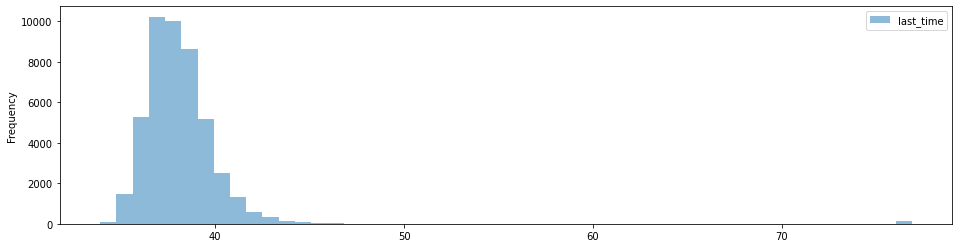

In [61]:
horse_df.plot(kind='hist', y='last_time' , bins=50, figsize=(16,4), alpha=0.5)

### odds

In [62]:
horse_df['odds']= horse_df['odds'].astype(float)

### horse dataの保存

In [63]:
print(horse_df.dtypes)
horse_df.head(3)

race_id                       object
rank                          object
frame_number                   int64
horse_number                   int64
horse_id                      object
age                            int64
burden_weight                float64
rider_id                      object
goal_time                    float64
half_way_rank                float64
last_time                    float64
odds                         float64
popular                      float64
horse_weight                 float64
tamer_id                      object
owner_id                      object
date                  datetime64[ns]
is_down                        int64
is_senba                       int64
is_mesu                        int64
is_osu                         int64
distance                       int64
avg_velocity                 float64
horse_weight_dif             float64
burden_weight_rate           float64
dtype: object


,race_id,rank,frame_number,horse_number,horse_id,age,burden_weight,rider_id,goal_time,half_way_rank,last_time,odds,popular,horse_weight,tamer_id,owner_id,date,is_down,is_senba,is_mesu,is_osu,distance,avg_velocity,horse_weight_dif,burden_weight_rate
0,200805010502,1,3,4,2005105185,3,54.0,1085,80.6,1.0,37.7,7.6,3.0,454.0,1017,853002,2008-02-16 10:30:00,0,0,1,0,1300,16.129032,0.0,0.118943
1,200805010502,2,6,10,2005106076,3,54.0,663,80.6,2.5,37.6,5.1,2.0,478.0,1064,138800,2008-02-16 10:30:00,0,0,1,0,1300,16.129032,0.0,0.112971
2,200805010502,3,8,14,2005102725,3,56.0,684,81.2,7.5,37.6,10.2,4.0,474.0,1074,226800,2008-02-16 10:30:00,0,0,0,1,1300,16.009852,0.0,0.118143


In [65]:
horse_df.to_csv("csv_cleaned/horse_data.csv", index=False )

## sire csv

In [66]:
sire_df = pd.read_csv("./csv/sire.csv", sep=",")
sire_df.head(2)

In [68]:
sire_df.to_csv("csv_cleaned/sire.csv", index=False )

## ped id csv

In [69]:
ped_id_df = pd.read_csv("./csv/ped_id.csv", sep=",")
ped_id_df.head(2)

,horse_id,f_id,mf_id,mmf_id,fmf_id
0,2015100929,2001103890,000a0022a2,000a001a8f,000a001d7e
1,2007105538,1995103211,1989109102,000a0003bb,000a0003bd


In [72]:
ped_id_df.isnull().sum()

horse_id    0
f_id        0
mf_id       4
mmf_id      4
fmf_id      0
dtype: int64

In [73]:
ped_id_df.to_csv("csv_cleaned/ped_id.csv", index=False )